<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tegashiki**

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing


In [2]:
from google.colab import auth
auth.authenticate_user()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [4]:
get_if_necessary("dictionary2.txt.gz")

Copying gs://karino2-tegashiki/dataset/dictionary2.txt.gz...
/ [1 files][  546.0 B/  546.0 B]                                                
Operation completed over 1 objects/546.0 B.                                      


In [5]:
train_raw_list = get_and_load("crohme2019_fixed_train_tokenized.pkl.gz")
valid_raw_list = get_and_load("crohme2019_fixed_valid_tokenized.pkl.gz")
# train_raw_small = get_and_load("crohme2019_fixed_train_tokenized_small.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_train_tokenized.pkl.gz...
/ [1 files][ 20.5 MiB/ 20.5 MiB]                                                
Operation completed over 1 objects/20.5 MiB.                                     
Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_valid_tokenized.pkl.gz...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [0]:
with gzip.open("dictionary2.txt.gz", "rt") as f:
  sym2id = {tup[0]:int(tup[1]) for tup in [line.rstrip().split() for line in f]}

In [0]:
def rawlabels2df(rawlists):
  label_id_dict = {tup[0]: ",".join(map(lambda x:str(sym2id[x]), tup[3])) for tup in rawlists}
  return pd.DataFrame(label_id_dict.items(), columns=["file", "exp_ids"])

In [0]:
train_labels = rawlabels2df(train_raw_list)

In [9]:
train_labels.shape

(9862, 2)

In [10]:
train_labels.head()

,file,exp_ids
0,Train/INKMLs/Train_2014/formulaire028-equation...,"77,47,65,7,51,47,65"
1,Train/INKMLs/Train_2014/formulaire014-equation...,"83,57,29,75,57,65,110,34,109,75,57,65,110,110,..."
2,Train/INKMLs/Train_2014/2009212-952-47.inkml,"38,64,90"
3,Train/INKMLs/Train_2014/formulaire010-equation...,"90,34,90,93,65"
4,Train/INKMLs/Train_2014/200923-1251-173.inkml,109


### Setup decoder input and target for training

In [0]:
BEGIN_OF_SEQ = 112
END_OF_SEQ=0

# MAX_TEX_LEN=206+2
# +2 is bos, eos
MAX_TRAIN_LEN=88+2

VOCAB_SIZE=113

In [0]:
def traindf2decoder_data_tuple(traindf, maxtklen=MAX_TRAIN_LEN):
  decoder_input_data = np.zeros(
      (len(traindf), maxtklen),
      dtype='uint8')
  
  decoder_target_data = np.zeros(
    (len(traindf), maxtklen, VOCAB_SIZE),
    dtype='uint8')
  
  decoder_sparse_target_data = np.zeros(
    (len(traindf), maxtklen),
    dtype='uint8')

  for i, row in traindf.iterrows():
    seq = [BEGIN_OF_SEQ] + [int(s) for s in row['exp_ids'].split(",")]
    decoder_input_data[i, 0:len(seq)] =seq
    decoder_target_data[i, 0:(len(seq)-1), :] =  np.eye(VOCAB_SIZE)[decoder_input_data[i, 1:len(seq)]]
    decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]
  return decoder_input_data, decoder_target_data, decoder_sparse_target_data

In [0]:
decoder_input_data, decoder_target_data, decoder_sparse_target_data = traindf2decoder_data_tuple(train_labels)

### Encoder input setup

In [0]:
# MAX_STROKE_SEQ_LEN=2773
# MAX_STROKE_SEQ_LEN=3193
MAX_STROKE_SEQ_LEN=1948

MAX_VALID_LEN=206+2
# MAX_VALID_STROKE_LEN=6620
MAX_VALID_STROKE_LEN=1154

NORMALIZE_MAX=2000

In [0]:
INPUT_TYPE_POINT=1
INPUT_TYPE_SEP=2
INPUT_TYPE_END=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

In [16]:
rdp_stroke_input = get_and_load("stroke_input_rdp_train.pkl.gz")
rdp_stroke_input_valid = get_and_load("stroke_input_rdp_valid.pkl.gz")

Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_train.pkl.gz...
/ [1 files][ 10.6 MiB/ 10.6 MiB]                                                
Operation completed over 1 objects/10.6 MiB.                                     
Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_valid.pkl.gz...
/ [1 files][977.8 KiB/977.8 KiB]                                                
Operation completed over 1 objects/977.8 KiB.                                    


### Build model for training

### Model

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, Reshape, Concatenate
from tensorflow.keras.layers import TimeDistributed, Flatten, Lambda, Add, Activation, Masking, Embedding
from tensorflow.keras.layers import AveragePooling1D, Conv1D, MaxPooling1D, SpatialDropout1D
import  tensorflow.keras.layers as layers
# from tensorflow.keras.layers.embeddings import Embedding
import tensorflow.keras.backend as K

In [0]:
# model_vec_mask3

EMBEDDING_SIZE=256
OT_HIDDEN=256
GRU_HIDDEN=256
ATTENTION_ENC_HIDDEN=256
ATTENTION_DEC_HIDDEN=256


# model_small
# EMBEDDING_SIZE=32
# OT_HIDDEN=128
# GRU_HIDDEN=128
# ATTENTION_ENC_HIDDEN=64
# ATTENTION_DEC_HIDDEN=64

# model_small_embed acc 0.22
# EMBEDDING_SIZE=32

# OT_HIDDEN=256
# GRU_HIDDEN=256
# ATTENTION_ENC_HIDDEN=256
# ATTENTION_DEC_HIDDEN=256



 https://arxiv.org/abs/1803.01271

try to cover 500 len. and attention will handle larger case.
As paper noted, best kernel size depend on task.
I start from k=8 because our task is somewhat similar to P-MNIST, and k=8 is best for that task.

In [0]:
import math

In [0]:
1+499/14

36.642857142857146

In [0]:
# 1+2*(k-1)*(2^n-1) #> 500
# 1+2*7*(2^n-1) > 500
# 2^n-1 > 499/14
# 2^n > 1+499/14
math.log2(1+ (499/14.0))

5.19546009354945

I set n = 6

In [0]:
2**0

1

In [0]:
# TCN residual block in paper
# filter_size must be the same as out_channels?

# filter_size=32
def TCNResBlock(input, layer_depth, filter_size=3, kernel_size=8, dropout_rate=0.2):
  d = 2**layer_depth
  x = Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal')(input)
  
  # https://github.com/ychfan/tf_estimator_barebone/blob/master/common/layers.py
  # weight norm implementation. But I use layer_norm for first trial.
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)

  x = Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal')(x)
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)
  return tf.nn.relu(x + input)


In [0]:
def TCN(input, depth=6):
  x = input
  for i in range(depth):
    x = TCNResBlock(x, i)
  return x

In [0]:
# block = TCNResBlock(input_from_encoder_t, 1)
# tmp = TCN(input_from_encoder_t)
# tmp.shape

In [0]:
def attention_context(ht_enc, ht_dec, maxtklen):
  w1 = Dense(ATTENTION_ENC_HIDDEN)(ht_enc)
  w2 = Dense(ATTENTION_DEC_HIDDEN)(ht_dec)
  # w1 (sample, 276, 256)
  # w2 (samples, 90, 256)


  w2_widen = tf.expand_dims(w2, axis=1)
  # (sample, 1, 90, 256)

  w1_widen = tf.expand_dims(w1, axis=2)
  # (sample, 276, 1, 256)

  w1_widen_repeat = K.repeat_elements(w1_widen, rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)

  score =tf.nn.tanh(w1_widen_repeat+w2_widen)
  prob = Dense(1, activation="softmax")(score)
  # score: (sample, 276, 90, 256)
  # prob: (sample, 276, 90, 1)

  ht_enc_repeated = K.repeat_elements(tf.expand_dims(ht_enc, axis=2), rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)

  context_vec = tf.reduce_sum(prob*ht_enc_repeated, axis=1)
  # (sample, 90, 256)

  return context_vec  


#input_from_encoder_t (8190, 2773, 3)

def create_model(input_from_encoder_t, decoder_input_t, maxtklen=MAX_TRAIN_LEN):
  conved = TCN(input_from_encoder_t)
  
  pooled = AveragePooling1D(10)(conved)
  # pooled = MaxPooling1D(10)(conved)
  # TensorShape([Dimension(None), Dimension(276), Dimension(32)])

  # ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True)(pooled)
  # ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True)(conved)
  # ht_enc (Sample, 276, 256)
  # state_enc (sample, 256)
  ht_enc = pooled
  
  # masked_dec = Masking(mask_value = 0)(decoder_input_t)
  
  # dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=maxtklen)(masked_dec)
  dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=maxtklen)(decoder_input_t)
  # (batch, 98, 256)


  # (sample, timestamps, htdim)
  # ht_dec = GRU(GRU_HIDDEN, return_sequences=True)(dec_input_embedded, initial_state=state_enc)
  ht_dec = GRU(GRU_HIDDEN, return_sequences=True)(dec_input_embedded)

  context_vec = attention_context(ht_enc, ht_dec, maxtklen)
  # context_vec = attention_context(conved, ht_dec, maxtklen)
  # (sample, 90, 256)

  # ht: (sample, 98, 256)
  # ot_input: (sample, 98, 1536) 

  ot_input = Concatenate()([ht_dec, context_vec])

  # (Sample, 98, 256)
  ot = Dense(OT_HIDDEN, activation="tanh")(ot_input)

  # (Sample, 98, 112)
  logit = TimeDistributed(Dense(VOCAB_SIZE))(ot)

  return logit


## Training

In [0]:
def sparse_softmax_cross_entropy_with_mask(sparse_labels, logit, mask):
  mask = tf.cast(mask, tf.float32)
  mask_expands = tf.expand_dims(mask, axis=2)
  return tf.losses.sparse_softmax_cross_entropy(sparse_labels, logit, mask_expands)

In [25]:
from tqdm.autonotebook import tqdm as tqdmn

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Overfit test

### One sample overfitting

In [0]:
stroke_input_t = tf.placeholder(tf.float32, shape=[1, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM], name='stroke_input')
decoder_input_t = tf.placeholder(tf.int32, shape=[1, MAX_TRAIN_LEN], name='input_decoder')


In [0]:
# decoder_label_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN, VOCAB_SIZE])
decoder_sparse_label_t = tf.placeholder(tf.int32, shape=[None, MAX_TRAIN_LEN])

In [0]:
input_from_encoder_t = stroke_input_t

In [0]:
stroke_input[13:14].shape

(1, 2773, 3)

In [0]:
one_enc_out = stroke_input[13:14]
one_dec_input = decoder_input_data[13:14]
# one_dec_label = decoder_target_data[13:14]
one_dec_label = decoder_sparse_target_data[13:14]


In [0]:
logit = create_model(stroke_input_t, decoder_input_t)

In [0]:
mask = tf.not_equal(decoder_input_t, 0)

In [0]:
loss = sparse_softmax_cross_entropy_with_mask(decoder_sparse_label_t, logit, mask, VOCAB_SIZE)

In [0]:
mask.shape

TensorShape([Dimension(1), Dimension(90)])

In [0]:
logit.shape

TensorShape([Dimension(1), Dimension(90), Dimension(113)])

In [0]:
tf.boolean_mask(logit, mask, axis=1) 

ValueError: ignored

ValueError: ignored

In [0]:
loss = tf.losses.softmax_cross_entropy(decoder_label_t, logit)

In [0]:
# optimizer = tf.train.AdamOptimizer(0.00009)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [0]:
for i in tqdmn(range(300)):
  _, loss_value = sess.run((train_op, loss), feed_dict={input_from_encoder_t:one_enc_out, decoder_input_t: one_dec_input, decoder_label_t: one_dec_label })
  if (i%10) == 0:
    print("{},{}".format(i, loss_value))

0,0.4299021065235138
10,0.28978899121284485
20,0.2812119424343109
30,0.2887258231639862
40,0.2877589464187622
50,0.28265517950057983
60,0.27853256464004517
70,0.27518272399902344
80,0.27324378490448
90,0.27216634154319763
100,0.2630217373371124
110,0.2537188231945038
120,0.2472420185804367
130,0.23482497036457062
140,0.2228134572505951
150,0.20941996574401855
160,0.1997656524181366
170,0.18890853226184845
180,0.17719601094722748
190,0.16441607475280762
200,0.1501675248146057
210,0.1344040334224701
220,0.1199604868888855
230,0.11128205060958862
240,0.0968426987528801
250,0.08818613737821579
260,0.08243891596794128
270,0.07542694360017776
280,0.06591439992189407
290,0.057869233191013336



### Small samples overfitting

In [0]:
batch_decoder_input, batch_decoder_target = create_decoder_input_target(one_batch_keys)

In [0]:
one_batch_pad = pad_batch(one_batch)

In [0]:
decoder_label_t.shape

TensorShape([Dimension(None), Dimension(90), Dimension(112)])

In [0]:
def run_training(input_enc, input_dec, label_dec, epochs):
  for i in tqdmn(range(epochs)):
    _, loss_value = sess.run((train_op, loss), feed_dict={input_from_encoder_t:input_enc, decoder_input_t: input_dec, decoder_label_t: label_dec})
    if (i%10) == 0:
      print("{},{}".format(i, loss_value))
  print("{},{}".format(i, loss_value))

In [0]:
for i in tqdmn(range(30)):
  _, loss_value = sess.run((train_op, loss), feed_dict={input_from_encoder_t:stroke_input[0:14], decoder_input_t: decoder_input_data[0:14], decoder_label_t: decoder_target_data[0:14] })
  if (i%10) == 0:
    print("{},{}".format(i, loss_value))
print("{},{}".format(i, loss_value))

0,0.734321117401123
10,0.5747506022453308
20,0.5645447969436646

29,0.5663236975669861


In [0]:
run_training(stroke_input[0:14], decoder_input_data[0:14], decoder_target_data[0:14], 100)

0,0.5643695592880249
10,0.5619446635246277
20,0.5679872632026672
30,0.5686002969741821
40,0.5664798021316528
50,0.5650796294212341
60,0.5649513006210327
70,0.5644221305847168
80,0.5636810660362244
90,0.5627249479293823

99,0.5624219179153442


In [0]:
optimizer = tf.train.AdamOptimizer(0.00009)
# optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [0]:
all_loss = []

In [0]:
import matplotlib.pyplot as plt

In [0]:
plt.plot(range(1, len(all_loss)+1), all_loss, 'bo', label='Training loss')

In [0]:
for i in range(100):
  loss_value = run_one_epoch(one_batch, batch_decoder_input, batch_decoder_target)
  all_loss.append(loss_value)
  print("{},{}".format(i, loss_value))

In [0]:
plt.plot(range(100, len(all_loss)+1), all_loss[99:], 'bo', label='Training loss')

In [0]:
dump_and_send(all_loss, "plain_overfit_losses.pkl.gz")

om_

### Estimator

In [0]:
# run_training(stroke_input[0:14], decoder_input_data[0:14], decoder_target_data[0:14], 200)

In [0]:
def input_fn_2():
  return tf.estimator.inputs.numpy_input_fn({"input_stroke": stroke_input, "input_decoder": decoder_input_data},
                        decoder_sparse_target_data.astype(np.int32),
                       batch_size=8,
                       shuffle=True)


In [0]:
def eval_input_fn():
    ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input[0:4], "input_decoder": decoder_input_data[0:4]}, decoder_sparse_target_data[0:4]))
    return ds_inputs.batch(4)


In [0]:
def model_fn_eval(features, labels, mode, params):
  return model_fn(features, labels, mode, params, MAX_VALID_STROKE_LEN, MAX_VALID_LEN)

def model_fn_train(features, labels, mode, params):
  return model_fn(features, labels, mode, params, MAX_STROKE_SEQ_LEN, MAX_TRAIN_LEN)

def model_fn(features, labels, mode, params, maxstroke, maxtk):
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])
  input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])
  input_stroke = tf.reshape(input_stroke, shape=(-1, maxstroke, INPUT_TYPE_DIM))
  print("model_fn, stroke, inputdec, label")
  print(input_stroke.shape)
  print(input_for_dec.shape)
  print(labels.shape)
  print(features["input_stroke"])
  
  logit = create_model(input_stroke, input_for_dec, maxtklen=maxtk)
  
  mask = tf.not_equal(input_for_dec, 0)
  
  # masked_logit = tf.boolean_mask(logit, mask)

  mask_int = tf.cast(mask, tf.int64)
  predicted_classes = tf.math.argmax(logit,axis=2)*mask_int
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'logit': logit,
        'class_ids': predicted_classes*mask_int
        #        'class_ids': predicted_classes[:, :, tf.newaxis],
        #    'probabilities': tf.nn.softmax(logits),
        #    'logits': logits,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  
  # masked_labels = tf.boolean_mask(labels, mask)
  
  
  
  loss = sparse_softmax_cross_entropy_with_mask(labels, logit, mask)
  accuracy = tf.metrics.accuracy(labels=labels,
                                 predictions=predicted_classes,
                                 name='acc_op')
  
  metrics = {'accuracy': accuracy}
  tf.summary.scalar('accuracy', accuracy[1])

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=metrics)
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  
  return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
estimator = tf.estimator.Estimator(
    model_fn=model_fn_train,
#     model_dir="./model_vec3",
    params={
        'learning_rate': 0.00009,
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqe35nuyu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbfff3bfc18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
estimator.train(
    input_fn=input_fn_2(),
    steps=10)

INFO:tensorflow:Calling model_fn.
model_fn, stroke, inputdec, label
(?, 3193, 3)
(?, 90)
(?, 90)
Tensor("random_shuffle_queue_DequeueUpTo:2", shape=(?, 3193, 3), dtype=int64, device=/device:CPU:0)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpqe35nuyu/model.ckpt.
INFO:tensorflow:loss = 0.045505255, step = 1
INFO:tensorflow:Saving checkpoints for 10 into /tmp/tmpqe35nuyu/model.ckpt.
INFO:tensorflow:Loss for final step: 0.04191933.


In [0]:
!mkdir model_vec_org

In [0]:
!gsutil -m cp -r gs://karino2-tegashiki/models/model_vec/* ./model_vec_org

In [0]:
!cp -r model_vec_org model_vec4

In [0]:
!ls model_vec2

In [0]:
!gsutil ls gs://karino2-tegashiki/models/model_vec_export_30000

In [0]:
estimator = tf.estimator.Estimator(
    model_fn=model_fn_train,
#     model_dir="./model_vec3",
    params={
        'learning_rate': 0.00009,
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdxsghap6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc015831908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
estimator = tf.estimator.Estimator(
    model_fn=model_fn_train,
    model_dir="./model_vec4",
    params={
        'learning_rate': 0.00009,
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_vec4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f24d428bc88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
estimator.evaluate(
    input_fn=input_fn_2(),
    steps=10)

INFO:tensorflow:Calling model_fn.
model_fn, stroke, inputdec, label
(?, 2773, 3)
(?, 90)
(?, 90)
Tensor("random_shuffle_queue_DequeueUpTo:2", shape=(?, 2773, 3), dtype=int64, device=/device:CPU:0)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-21T12:59:56Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_vec4/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Finished evaluation at 2019-05-21-13:00:03
INFO:tensorflow:Saving dict for global step 30000: accuracy = 0.5497222, global_step = 30000, loss = 3.334193
IN

{'accuracy': 0.5497222, 'global_step': 30000, 'loss': 3.334193}

In [0]:
estimator.train(
    input_fn=input_fn_2(),
    steps=100)

### TPUEstimator

In [0]:
DATA_DIR="gs://karino2-tegashiki/dataset"
TF_RECORD_FILE="{}/crohme2019_rdp.tfrecord.gz".format(DATA_DIR)
TF_VALID_RECORD_FILE="{}/crohme2019_rdp_valid.tfrecord.gz".format(DATA_DIR)

In [0]:
# MODEL_DIR="gs://karino2-tegashiki/models/model_vec_mask3"
# MODEL_DIR="gs://karino2-tegashiki/models/model_vec_small"
# MODEL_DIR="gs://karino2-tegashiki/models/model_vec_mask3_rdp"
# MODEL_DIR="gs://karino2-tegashiki/models/small_rdp"
# MODEL_DIR="gs://karino2-tegashiki/models/full_nonpool_rdp" useup memory
# MODEL_DIR="gs://karino2-tegashiki/models/tcn_full" useup memory
# MODEL_DIR="gs://karino2-tegashiki/models/tcn_pool"
# MODEL_DIR="gs://karino2-tegashiki/models/tcn_avg"
# MODEL_DIR="gs://karino2-tegashiki/models/tcn_avg_fix"
# MODEL_DIR="gs://karino2-tegashiki/models/tcn_dropout"
MODEL_DIR="gs://karino2-tegashiki/models/tcn_dropout_lr"


In [28]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.106.75.146:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 3250442684909178229),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7710134610188920272),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13774316538090533902),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2703584816602541193),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5080301106667404602),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 16280023034675696518),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 12926065341526928796),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 17583978531542785012),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 35654384773

In [0]:
len(valid_labels)

958

In [0]:
VALID_SAMPLE_NUM=958 # len(valid_labels)
TRAIN_STEP_PER_ONCE=1000
EVAL_BATCH_SIZE=8

In [0]:
def parser(serialized_example, maxstrokelen, maxtklen):
  features = tf.parse_single_example(
      serialized_example,
      features={
      'input_x': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'input_y': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'input_type': tf.FixedLenFeature([maxstrokelen], tf.int64),
      'decoder_input':tf.FixedLenFeature([maxtklen], tf.int64),
      'decoder_labels':tf.FixedLenFeature([maxtklen], tf.int64)}          
  )
  
  
  input_x = tf.cast(features['input_x'], tf.int32)
  input_y = tf.cast(features['input_y'], tf.int32)
  input_type = tf.cast(features['input_type'], tf.int32)
  # one_sample_stroke = tf.stack([input_x, input_y, input_type], 0)
  one_sample_stroke = tf.concat([input_x, input_y, input_type], 0)
  decoder_input = tf.cast(features["decoder_input"], tf.int32)
  decoder_labels = tf.cast(features["decoder_labels"], tf.int32)
  
  return {"input_stroke": one_sample_stroke, "input_decoder": decoder_input} , decoder_labels

def parser_train(serialized_example):
  return parser(serialized_example, MAX_STROKE_SEQ_LEN, MAX_TRAIN_LEN)

def parser_valid(serialized_example):
  return parser(serialized_example, MAX_VALID_STROKE_LEN, MAX_VALID_LEN)



In [0]:

def tpu_input_fn(params):
  dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser_train)
  dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

def tpu_input_fn_valid(params):
  dataset = tf.data.TFRecordDataset(TF_VALID_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser_valid)
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

def tpu_input_fn_predict_trainset(params):
  dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser_train)
  dataset = dataset.take(500)
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

In [0]:

def metric_fn(labels, logits, predicted_classes, mask_weights):
    """Function to return metrics for evaluation."""

      
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   weights=mask_weights,
                                   name="acc_op")
    return {"accuracy": accuracy}

def extract_params(features, mode, params):  
  if mode == tf.estimator.ModeKeys.TRAIN:
    input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])
    input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])

    input_stroke = tf.reshape(input_stroke, shape=(-1, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))
    maxtklen = MAX_TRAIN_LEN
  else:
    input_stroke = tf.feature_column.input_layer(features, params['input_stroke_valid'])
    input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec_valid'])

    input_stroke = tf.reshape(input_stroke, shape=(-1, MAX_VALID_STROKE_LEN, INPUT_TYPE_DIM))
    maxtklen = MAX_VALID_LEN
  return (input_stroke, input_for_dec, maxtklen)

def extract_params_always_train(features, mode, params):
  return extract_params(features, tf.estimator.ModeKeys.TRAIN, params)
  
def tpu_model_fn(features, labels, mode, params):
  input_stroke, input_for_dec, maxtklen = extract_params(features, mode, params)
  # input_stroke, input_for_dec, maxtklen = extract_params_always_train(features, mode, params)
  
  logit = create_model(input_stroke, input_for_dec, maxtklen)
  
  
  mask = tf.not_equal(input_for_dec, 0)
  mask_int = tf.cast(mask, tf.int64)
  
  predicted_classes = tf.math.argmax(logit,axis=2)*mask_int
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        "class_ids": predicted_classes[:, tf.newaxis],
        "logits": logit,
    }
    return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)  
  
  loss = sparse_softmax_cross_entropy_with_mask(labels, logit, mask)

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, logit, predicted_classes, tf.cast(mask, tf.float32)]))
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])  
  optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)  
  
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op)


In [0]:
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)

In [0]:
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver,
    master=None,
    model_dir=MODEL_DIR,
    save_checkpoints_steps=100,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=1000,
        num_shards=8,
        per_host_input_for_training=is_per_host
        # per_host_input_for_training=False
    ))

In [48]:
tpu_estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=tpu_model_fn,
    config=run_config,
    export_to_tpu=False, # Conv1D cause error for TPU graph with ReadVariableOp. why?
    params={
        'learning_rate': 0.00009,
#        'learning_rate': 0.001,
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,)),
        'input_stroke_valid':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_VALID_STROKE_LEN, INPUT_TYPE_DIM)),
        'input_for_dec_valid': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_VALID_LEN,))
    },
    train_batch_size=8*32,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=8)

INFO:tensorflow:Using config: {'_model_dir': 'gs://karino2-tegashiki/models/tcn_dropout_lr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.106.75.146:8470"
    }
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4a4f962898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.106.75.146:8470', '_evaluation_master': 'grpc://10.106.75.146:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=8, 

In [0]:
def get_global_step(estimator):
  try:
    return int(estimator.get_variable_value("global_step"))
  except ValueError:
    return 0
      
def train_tpu_estimator(max_steps):
  step = get_global_step(tpu_estimator)+TRAIN_STEP_PER_ONCE
  while step < max_steps:
    tpu_estimator.train(
      input_fn = tpu_input_fn,
      max_steps=step)
    eval_results = tpu_estimator.evaluate(
      input_fn=tpu_input_fn_valid,
      steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)
    print(step)
    print(eval_results)
    step += TRAIN_STEP_PER_ONCE
  tpu_estimator.train(
    input_fn = tpu_input_fn,
    max_steps=max_steps)
  eval_results = tpu_estimator.evaluate(
    input_fn=tpu_input_fn_valid,
    steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)


In [51]:
train_tpu_estimator(5000)

INFO:tensorflow:Querying Tensorflow master (grpc://10.106.75.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3250442684909178229)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7710134610188920272)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 13774316538090533902)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2703584816602541193)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5080301106667404602)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into gs://karino2-tegashiki/models/tcn_dropout_lr/model.ckpt.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Installing graceful shutdown hook.
INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR

INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 7 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1000) batch(es) of data from outfeed.
INFO:tensorflow:Saving checkpoints for 1000 into gs://karin

In [54]:
train_tpu_estimator(50000)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://karino2-tegashiki/models/tcn_dropout_lr/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30000 into gs://karino2-tegashiki/models/tcn_dropout_lr/model.ckpt.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Installing graceful shutdown hook.
INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR

INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 7 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.
INFO:tensorflow:Deq

In [0]:
train_tpu_estimator(60000)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://karino2-tegashiki/models/tcn_dropout_lr/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50000 into gs://karino2-tegashiki/models/tcn_dropout_lr/model.ckpt.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Installing graceful shutdown hook.
INFO:tensorflow:Creating heartbeat manager for ['/job:worker/replica:0/task:0/device:CPU:0']
INFO:tensorflow:Configuring worker heartbeat: shutdown_mode: WAIT_FOR_COORDINATOR

INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 10 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Enqueue next (1000) batch(es) of data to infeed.
INFO:tensorflow:De

### Evaluate result

In [0]:
predictions = tpu_estimator.predict(input_fn=tpu_input_fn_valid)
pred_res = list(predictions)

INFO:tensorflow:Querying Tensorflow master (grpc://10.9.98.162:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13729412150682042289)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3943709997331902754)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9486574995663304763)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 319607514878267032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2382116045830419397)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/jo

In [0]:
id2sym = {value:key for key,value in sym2id.items() }

In [0]:
def tosym(ids):
  return [id2sym[id] for id in ids]

In [0]:
tosym(pred_res[0]['class_ids'][0][0:13])

['n', 'n', '{', '(', 'r', 'o', 'S', 'M', 'n', 'm', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(sparse_label_dec[0][0:13])

['C', '_', 't', '=', 'C', '+', 'C', '=', '2', 'C', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(pred_res[1]['class_ids'][0][0:18])

['\\frac',
 '{',
 '{',
 '2',
 '{',
 '2',
 '}',
 '}',
 '}',
 '{',
 'a',
 '_',
 '{',
 'n',
 '_',
 '(',
 '\\limits',
 '<eol>']

In [0]:
tosym(sparse_label_dec[1][0:18])

['\\frac',
 '{',
 '\\log',
 '_',
 '{',
 'b',
 '}',
 'x',
 '}',
 '{',
 '\\log',
 '_',
 '{',
 'b',
 '}',
 'a',
 '}',
 '<eol>']

In [0]:
tosym(pred_res[2]['class_ids'][0][0:13])

['\\frac', '{', '\\frac', '}', '{', '(', '1', 'y', '^', '{', '}', ')', '{']

In [0]:
tosym(sparse_label_dec[2][0:13])

['\\sqrt', '{', 'v', '^', '2', '-', '{', 'v', '_', 'v', '}', '^', '2']

Model seems overfitting.
Confirm by using the same input of training set(need to adjust tpu_model_fn too)

In [0]:
predictions = tpu_estimator.predict(input_fn=tpu_input_fn_predict_trainset)
pred_res2 = list(predictions)


INFO:tensorflow:Querying Tensorflow master (grpc://10.9.98.162:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13729412150682042289)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3943709997331902754)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 9486574995663304763)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 319607514878267032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2382116045830419397)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/jo

In [0]:
tosym(pred_res2[0]['class_ids'][0][0:10])

['1', '_', '{', '=', '\\ldots', '_', '2', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(decoder_sparse_target_data[0][0:10])

['f', '_', '2', ',', 'g', '_', '2', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(pred_res2[1]['class_ids'][0][0:10])

['\\frac', '{', '1', '^', '2', '2', '}', '+', 'x', '^']

In [0]:
tosym(decoder_sparse_target_data[1][0:10])

['\\frac', '{', 'x', '^', '{', '2', '}', '+', 'y', '^']

In [0]:
tosym(pred_res2[2]['class_ids'][0][0:10])

['{', '.', '7', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>']

In [0]:
tosym(decoder_sparse_target_data[2][0:10])

['7', '.', '1', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>', '<eol>']

In [0]:
decoder_input_data[0:5]

array([[112,  77,  47,  65,   7,  51,  47,  65,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,  83,  57,  29,  75,  57,  65, 110,  34, 109,  75,  57,  65,
        110, 110,  57, 102,  75,  57,  65, 110, 110,  89,  83,  57,  49,
         75,  57,  65, 110, 110,  57,  48,  75,  57,  65, 110, 110,  34,
         90,  93,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [0]:
tosym(sparse_label_dec[0][0:10])

['C', '_', 't', '=', 'C', '+', 'C', '=', '2', 'C']

In [0]:
tosym(pred_res[1]['class_ids'][0][0:13])

['f', '{', '2', 'x', '2', '2', '-', '}', '}', '{', '2', '_', '{']

In [0]:
tosym(sparse_label_dec[1][0:10])

['\\frac', '{', '\\log', '_', '{', 'b', '}', 'x', '}', '{']

In [0]:
tosym(pred_res[2]['class_ids'][0][0:13])

['a', 'u', '\\int', 't', '2', '2', '+', '2', '+', '2', 'a', '_', '3']

In [0]:
tosym(sparse_label_dec[2][0:10])

['s', 'q', 'r', 't', '{', 'v', '^', '2', '-', '{']

In [0]:
valid_raw_list[2]

('valid/TestEM2014GT_INKMLs/502_em_16.inkml',
 '\\sqrt{v^2-{v_v}^2}=\\frac {{v_v}^2}{\\sqrt{v^2-{v_v}^2}}',
 ['s',
  'q',
  'r',
  't',
  '{',
  'v',
  '^',
  '2',
  '-',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '=',
  '\\frac',
  '{',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '{',
  '\\sqrt',
  '{',
  'v',
  '^',
  '2',
  '-',
  '{',
  'v',
  '_',
  'v',
  '}',
  '^',
  '2',
  '}',
  '}'],
 ['260 181, 260 180, 262 177, 263 175, 264 174, 266 171, 268 170, 269 170, 271 170, 272 171, 273 173, 273 175, 274 178, 274 181, 274 184, 274 187, 276 192, 278 194, 280 194, 282 195, 287 193, 289 191, 291 188, 292 185, 293 182, 293 179, 293 176, 293 174, 292 172, 291 171, 290 170, 289 171, 288 170, 295 174, 297 174, 299 173, 300 172, 301 171, 300 172, 301 171',
  '321 137, 320 137, 320 136, 322 132, 323 132, 323 133, 323 137, 322 140, 321 142, 319 144, 317 146, 315 147, 313 148, 312 148, 312 147, 314 145, 316 145, 317 146, 319 146, 320 147, 322 148, 324 149, 326 150,

### TensorBoard

In [38]:
!git clone https://github.com/mixuala/colab_utils

Cloning into 'colab_utils'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 2.35 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [0]:
kill_tensorboard()

In [50]:
import os
import colab_utils.tboard

ROOT = %pwd
colab_utils.tboard.launch_tensorboard(bin_dir=ROOT, log_dir=MODEL_DIR)

ngrok installed
status: tensorboard=False, ngrok=False
tensorboard url= https://8211f534.ngrok.io


'https://8211f534.ngrok.io'

In [0]:
import re

def find_one_command(res_arr, word):
  return list(filter(lambda arr: arr[4] == word, res_arr))[0]

def kill_tensorboard():
  ps_res = !ps
  res_arr = [re.split(r' +', one) for one in ps_res[1:]]
  pid_ngrok = find_one_command(res_arr, "ngrok")[1]
  pid_tb = find_one_command(res_arr, "tensorboard")[1]
  !kill {pid_ngrok}
  !kill {pid_tb}

In [0]:
# kill_tensorboard()

In [0]:
MODEL_DIR

'gs://karino2-tegashiki/models/tcn_pool'

In [0]:
ps_res = !ps

In [0]:
res_arr = [re.split(r' +', one) for one in ps_res[1:]]

In [0]:
find_one_command(res_arr, "ngrok")

['', '2836', '?', '00:00:10', 'ngrok']

In [0]:
find_one_command(res_arr, "tensorboard")

['', '2833', '?', '00:01:04', 'tensorboard']

In [0]:
pid_ngrok = find_one_command(res_arr, "ngrok")[1]
pid_ngrok

'2836'

In [0]:
!kill 2833

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      7 ?        00:00:22 node
     24 ?        00:00:51 jupyter-noteboo
    116 ?        00:00:00 tail
    124 ?        00:26:11 python3
    167 ?        00:00:00 python3
   2833 ?        00:01:19 tensorboard
   3718 ?        00:00:00 ps


In [0]:
list(filter(lambda arr: arr[4] == "ngrok", res_arr))

[['', '2836', '?', '00:00:10', 'ngrok']]

In [0]:
re.split(r' +', ps_res[1])

['', '1', '?', '00:00:00', 'run.sh']

In [0]:
!kill 10785
!kill 10788

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      6 ?        00:00:19 node
     21 ?        00:00:46 jupyter-noteboo
    111 ?        00:00:01 tail
    120 ?        00:00:56 python3
    400 ?        00:00:00 python3
   7345 ?        00:00:47 python3
   7406 ?        00:00:00 python3
   8279 ?        00:00:00 ps


## Data setup (only once)

In [0]:
def strokearr2poslislis(strokearr):
  res = []
  
  for line in strokearr:
    res.append([(float(pair[0]),float(pair[1])) for pair in [pos.strip().split(" ") for pos in line.split(",")]])
  return res

def normalize_poslislis(poslislis):
    maxval = max(max(tup) for poslis in poslislis for tup in poslis)
    ratio = NORMALIZE_MAX/maxval
    return [(ratio*np.array(poslis)).astype(int) for poslis in poslislis]
    

In [0]:
def poslislis2vec(poslislis):
  """To list of 3D vector (x, y, TYPE).
  put (0, 0, INPUT_TYPE_SEP) between stroke.
  put (0, 0, INPUT_TYPE_END) at end.
  """
  res = None
  for one_stroke in poslislis:
    # onestoke (size, 2)
    widen = INPUT_TYPE_POINT*np.ones((one_stroke.shape[0], 3), dtype=int)
    widen[:, :-1] = one_stroke

    # Compare to None cause broadcast for np.array.
    if type(res) != np.ndarray:
      res = np.concatenate((widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
    else:
      res = np.concatenate((res, widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
  res[-1, 2] = INPUT_TYPE_END
  return res

In [0]:
def training_list_to_stroke_input_data(training_list, maxstrokelen=MAX_STROKE_SEQ_LEN):
  stroke_input_data = np.zeros(
    (len(training_list), maxstrokelen, INPUT_TYPE_DIM),
    dtype='int')
  for i, tup in enumerate(training_list):
    lislis = strokearr2poslislis(tup[4])
    lislis = normalize_poslislis(lislis)
    vec = poslislis2vec(lislis)
    stroke_input_data[i,0:vec.shape[0], : ] = vec
  return stroke_input_data

In [0]:
stroke_input = training_list_to_stroke_input_data(train_raw_list)

In [0]:
stroke_input.shape

(9862, 3193, 3)

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
def rawlist2lislislis(raw_list):
  return [strokearr2poslislis(tup[4]) for tup in raw_list]

In [0]:
def lislislis2rdplis(lislislis, epsilon=0.05):
  rdplis = []
  for lislis in tqdmn(lislislis):
    reslislis = [rdp(one, epsilon=epsilon) for one in lislis]
    rdplis.append(reslislis)
  return rdplis

In [0]:
lislislis = rawlist2lislislis(train_raw_list)

In [0]:
len(lislislis)

9862

In [0]:
train_rdplis = lislislis2rdplis(lislislis)

In [0]:
def list3_to_max_stroke_len(list3):
  return max([len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3])


In [0]:
MAX_STROKE_SEQ_LEN

3193

In [0]:
list3_to_max_stroke_len(lislislis)

3193

In [0]:
list3_to_max_stroke_len(train_rdplis)

1948

In [0]:
def rdp_list3_to_stroke_input_data(rdp_list3, maxstrokelen):
  stroke_input_data = np.zeros(
    (len(rdp_list3), maxstrokelen, INPUT_TYPE_DIM),
    dtype='int')
  for i, lislis in enumerate(rdp_list3):
    lislis = normalize_poslislis(lislis)
    vec = poslislis2vec(lislis)
    stroke_input_data[i,0:vec.shape[0], : ] = vec
  return stroke_input_data

In [0]:
rdp_stroke_input = rdp_list3_to_stroke_input_data(train_rdplis, 1948)

In [0]:
rdp_stroke_input.shape

(9862, 1948, 3)

In [0]:
dump_and_send(rdp_stroke_input, "stroke_input_rdp_train.pkl.gz")

Copying file://stroke_input_rdp_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 10.6 MiB/ 10.6 MiB]                                                
Operation completed over 1 objects/10.6 MiB.                                     


In [0]:
valid_list3 = rawlist2lislislis(valid_raw_list)

In [0]:
len(valid_list3)

958

In [0]:
valid_rdplis = lislislis2rdplis(valid_list3)

In [0]:
list3_to_max_stroke_len(valid_rdplis)

1154

In [0]:
rdp_stroke_input_valid = rdp_list3_to_stroke_input_data(valid_rdplis, 1154)

In [0]:
dump_and_send(rdp_stroke_input_valid, "stroke_input_rdp_valid.pkl.gz")

Copying file://stroke_input_rdp_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][977.8 KiB/977.8 KiB]                                                
Operation completed over 1 objects/977.8 KiB.                                    


### Write to TFRecord

In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [0]:
def convert_to_example(one_stroke_sample, one_decoder_sample, one_label_sample):
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:, 0]),
      'input_y': _int64_feature(one_stroke_sample[:, 1]),
      'input_type': _int64_feature(one_stroke_sample[:, 2]),
      'decoder_input':_int64_feature(one_decoder_sample),
      'decoder_labels':_int64_feature(one_label_sample)}))
  return example

In [0]:
# convert_to_example(stroke_input[0], decoder_input_data[0], decoder_sparse_target_data[0])

In [0]:
def write_to_file(filename, stroke, decinput, sparselabels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i in range(len(stroke)):
      example = convert_to_example(stroke[i], decinput[i], sparselabels[i])
      writer.write(example.SerializeToString())


In [0]:
write_to_file("crohme2019_rdp.tfrecord.gz", rdp_stroke_input, decoder_input_data, decoder_sparse_target_data)

In [0]:
!ls -l crohme2019_rdp.tfrecord.gz

-rw-r--r-- 1 root root 8433277 May 25 03:22 crohme2019_rdp.tfrecord.gz


In [0]:
send_file("crohme2019_rdp.tfrecord.gz")

Copying file://crohme2019_rdp.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][  8.0 MiB/  8.0 MiB]                                                
Operation completed over 1 objects/8.0 MiB.                                      


- crohme2019.tfrecord.gz first version
- crohme2019_fixed.tfrecord.gz fix filter version (initial sqrt handling, etc.)
- crohme2019_rdp.tfrecord.gz apply rdp reduction with epsilon 0.05 to above record

In [0]:
valid_labels = rawlabels2df(valid_raw_list)

In [0]:
valid_labels.shape

(958, 2)

In [0]:
MAX_VALID_LEN=206+2
# MAX_VALID_STROKE_LEN=6620

In [0]:
input_dec, label_dec, sparse_label_dec = traindf2decoder_data_tuple(valid_labels, maxtklen=MAX_VALID_LEN)

In [0]:
input_dec.shape

(958, 208)

In [0]:
# valid_stroke = training_list_to_stroke_input_data(valid_raw_list, maxstrokelen=MAX_VALID_STROKE_LEN)

In [0]:
rdp_stroke_input_valid.shape

(958, 1154, 3)

In [0]:
valid_stroke.shape

(958, 6620, 3)

In [0]:
write_to_file("crohme2019_rdp_valid.tfrecord.gz", rdp_stroke_input_valid, input_dec, sparse_label_dec)

In [0]:
send_file("crohme2019_rdp_valid.tfrecord.gz")

Copying file://crohme2019_rdp_valid.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][754.4 KiB/754.4 KiB]                                                
Operation completed over 1 objects/754.4 KiB.                                    


# Try and error

In [0]:


def input_fn_with_batch(batch_size):
  ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input, "input_decoder": decoder_input_data}, decoder_sparse_target_data))
  # ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input[0:14], "input_decoder": decoder_input_data[0:14]}, decoder_target_data[0:14]))
  return ds_inputs.repeat().batch(batch_size)

def input_fn():
  return input_fn_with_batch(8)
  # ds_stroke = tf.data.Dataset.from_tensor_slices(stroke_input)
  # ds_decoder_input = tf.data.Dataset.from_tensor_slices(decoder_input_data)
  # ds_labels = tf.data.Dataset.from_tensor_slices(decoder_target_data)
  # ds_inputs = tf.data.Dataset.zip((ds_stroke, ds_decoder_input))
  # return tf.data.Dataset.zip((ds_inputs, ds_labels)).repeat().batch(200)

In [0]:
def model_fn(features, labels, mode, params):
  # input_from_enc = features["input_from_encoder"] # tf.feature_column.input_layer(features, params['input_from_enc'])
  # input_for_dec= features['decoder_input'] # tf.feature_column.input_layer(features, params['input_for_dec'])
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])
  input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])
  # input_from_enc = tf.expand_dims(input_from_enc, axis=0)
  #input_for_dec = tf.expand_dims(input_for_dec, axis=0)
  # labels = tf.expand_dims(labels, axis=0)
  # print(features["decoder_input"])
  # print(features["decoder_input"])
  # print(features["input_from_encoder"])
  input_stroke = tf.reshape(input_stroke, shape=(-1, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))
  print("model_fn, stroke, inputdec, label")
  print(input_stroke.shape)
  print(input_for_dec.shape)
  print(labels.shape)
  print(features["input_stroke"])
  
  logit = create_model(input_stroke, input_for_dec)
  
  
  predicted_classes = tf.math.argmax(logit,axis=2)
  # print("predclass")
  # print(predicted_classes.shape)
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'logit': logit,
        'class_ids': predicted_classes
        #        'class_ids': predicted_classes[:, :, tf.newaxis],
        #    'probabilities': tf.nn.softmax(logits),
        #    'logits': logits,
    }
    return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # print(labels.shape)
  # print(logit.shape)
  loss = tf.losses.sparse_softmax_cross_entropy(labels, logit)


  accuracy = tf.metrics.accuracy(labels=labels,
                                 predictions=predicted_classes,
                                 name='acc_op')
  
  metrics = {'accuracy': accuracy}
  tf.summary.scalar('accuracy', accuracy[1])

  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode, loss=loss, eval_metric_ops=metrics)
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])
  train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
  
  return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [0]:
MAX_TRAIN_LEN

90

In [0]:
MAX_STROKE_SEQ_LEN

2773

In [0]:
tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))

NumericColumn(key='input_stroke', shape=(2773, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))

NumericColumn(key='input_decoder', shape=(90,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
decoder_input_data.shape

NameError: ignored

In [0]:
3*2773

8319

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
for _ in range(100):
  estimator.train(
    input_fn=input_fn,
    steps=14)

In [0]:
print(estimator.model_dir)

In [0]:
!cp -r /tmp/tmpsprjnv8j ./estimator_model1_dir

In [0]:
for i, row in train_labels.iterrows():
    seq = [BEGIN_OF_SEQ] + [int(s) for s in row['exp_ids'].split(",")]
    decoder_input_data[i, 0:len(seq)] =seq
    decoder_target_data[i, 0:(len(seq)-1), :] =  np.eye(VOCAB_SIZE)[decoder_input_data[i, 1:len(seq)]]
    decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]

In [0]:
decoder_input_data.shape

(8190, 90)

In [0]:
decoder_target_data.shape

(8190, 90, 112)

In [0]:
decoder_input_data[0, 0:5]

array([111,  77,  47,  65,   7], dtype=uint8)

In [0]:
decoder_target_data[0, 0:3, 40:50]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
decoder_input_data.shape

(8190, 90)

In [0]:
bs = 32

In [0]:
def create_generator(x, batch_size):
    for i in range(len(x)//batch_size):
        yield x[i*batch_size : (i+1)*batch_size]


In [0]:
tmp = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])),
                                             args = ([stroke_input, bs]))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
tmp

<DatasetV1Adapter shapes: (?, 2773, 3), types: tf.int32>

In [0]:
def create_generator(x, batch_size):
    for i in range(len(x)//batch_size):
        yield x[i*batch_size : (i+1)*batch_size]

def tpu_input_fn(params):
  bs = params['batch_size'] 
  ds_stroke = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])),
                                             args = ([stroke_input, bs]))
                                             
  ds_decoder_input = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_TRAIN_LEN]),
                                              args = ([decoder_input_data.astype(np.int32), bs]))
  ds_labels = tf.data.Dataset.from_generator(create_generator, (tf.int32),
                                             (tf.TensorShape([None, MAX_TRAIN_LEN, VOCAB_SIZE]),
                                              args = ([decoder_target_data.astype(np.int32), bs]))
  
  
    # ds_stroke = tf.data.Dataset.from_tensor_slices(stroke_input)
  # ds_decoder_input = tf.data.Dataset.from_tensor_slices(decoder_input_data)
  # ds_labels = tf.data.Dataset.from_tensor_slices(decoder_target_data)
  # ds_inputs = tf.data.Dataset.zip((ds_stroke, ds_decoder_input))
  # return tf.data.Dataset.zip((ds_inputs, ds_labels)).repeat().batch(200)
  
  
  train_data = Data.Dataset.from_generator( generator= data_gen,
                                             output_types= ( tf.float32, tf.int32),
                                             output_shapes= ((bs, 28,28),(bs)) )

In [0]:
def data_gen(x=x_train , y= y_train, batch_size = 32 ):
    
    for i in range(len(x)//batch_size):
        yield (x[i*batch_size : (i+1)*batch_size], y[i*batch_size : (i+1)*batch_size])

        
        


In [0]:
BATCH_SIZE=16

In [0]:
def create_input_fn(batch_size):
  input_fn = tf.estimator.inputs.numpy_input_fn({"input_stroke": stroke_input,
                       "input_decoder": decoder_input_data.astype(np.int32)},
                        decoder_target_data.astype(np.int32),
                       batch_size=batch_size,
                       shuffle=True)
  return lambda params: input_fn()

In [0]:
def tpu_input_fn(params):
  return tf.estimator.inputs.numpy_input_fn({"input_stroke": stroke_input, "input_decoder": decoder_input_data},
                        decoder_target_data,
                       batch_size=params['batch_size'],
                       shuffle=True)


In [0]:
def tpu_input_fn_wrapper(params):
  # test_ds = tf.data.Dataset.from_tensor_slices(fdict)    
  # return test_ds.batch(params['batch_size'])
  # return input_fn_with_batch(params['batch_size'])
  #
  #TPU does not support uint8 as infeed type.
  ds_inputs = tf.data.Dataset.from_tensor_slices(({"input_stroke": stroke_input, 
                                                   "input_decoder": decoder_input_data.astype(np.int32)}, decoder_target_data.astype(np.int32)))
  ds = ds_inputs.shuffle(1000).repeat()
  ds = ds.batch(params['batch_size'], drop_remainder=True)
  return ds



In [0]:
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:, 0]),
      'input_y': _int64_feature(one_stroke_sample[:, 1]),
      'input_type': _int64_feature(one_stroke_sample[:, 2]),
      'decoder_input':_int64_feature(one_decoder_sample),
      'decoder_labels':_int64_feature(one_label_sample)}))


In [0]:
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=FLAGS.tpu_name)

is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    master=FLAGS.master,
    model_dir=FLAGS.output_dir,
    save_checkpoints_steps=FLAGS.save_checkpoints_steps,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=FLAGS.iterations_per_loop,
        num_shards=FLAGS.num_tpu_cores,
        per_host_input_for_training=is_per_host))

In [0]:
def tpu_model_fn_wrapper(features, labels, mode, params):
  tspec = model_fn(features, labels, mode, params)
  pred_dict = {'predictions': tspec.predictions}
  return tf.contrib.tpu.TPUEstimatorSpec(
          mode=tspec.mode, predictions=pred_dict, scaffold_fn=tspec.scaffold_fn)

In [0]:
tpu_estimator = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn,
    config=tf.contrib.tpu.RunConfig(),
    use_tpu=False)

In [0]:
class FLAGS(object):
    '''Parameters.'''
    def __init__(self):
        self.use_tpu = True
        self.output_dir = "gs://karino2-tegashiki/models/model1"
        # self.data_dir = "./bert/data/1000"
        self.init_checkpoint = INIT_CHECK_POINT
        # self.predict_batch_size = 16
        self.predict_batch_size = 1
        # TPU related
        self.num_tpu_cores = 8
        self.tpu_name = TPU_ADDRESS
        
        # self.max_seq_length = 512
        
        # The following parameters are not used in predictions.
        # Just use to create RunConfig.
        self.master = None
        self.save_checkpoints_steps = 1
        self.learning_rate = 0
        self.num_warmup_steps = 0
        self.num_train_steps = 0
        # TPU related. Some of these value have positive int not to make TPUEstimator angry (even though these are not used...).
        # self.eval_batch_size = 32
        # self.train_batch_size = 32 
        self.eval_batch_size = 1
        self.train_batch_size = 1 
        self.iterations_per_loop = 1000


In [0]:
import subprocess

use_tpu=False
tpu_name=None
model_dir = "gs://karino2-tegashiki/models/model1"
iterations = 50
num_shards = 8

my_project_name = subprocess.check_output([
    'gcloud','config','get-value','project'])
my_zone = subprocess.check_output([
    'gcloud','config','get-value','compute/zone'])

cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)


cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        tpu_names=[FLAGS.tpu_name],
        zone=my_zone,
        project=my_project)
master = tpu_cluster_resolver.get_master()

In [0]:
import subprocess

use_tpu=False
tpu_name=None
model_dir = "estimator_model1_dir"
iterations = 50
num_shards = 8

my_project_name = subprocess.check_output([
    'gcloud','config','get-value','project'])
my_zone = subprocess.check_output([
    'gcloud','config','get-value','compute/zone'])
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        tpu_names=[FLAGS.tpu_name],
        zone=my_zone,
        project=my_project)
master = tpu_cluster_resolver.get_master()

In [0]:
tpu_run_config = tf.contrib.tpu.RunConfig(
    master=master,
    evaluation_master=master,
    model_dir=FLAGS.model_dir,
    session_config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True),
    tpu_config=tf.contrib.tpu.TPUConfig(FLAGS.iterations,
                                        FLAGS.num_shards),
)

In [0]:
tpu_estimator = tf.contrib.tpu.TPUEstimator(
    model_fn=model_fn,
    config=tf.contrib.tpu.RunConfig(),
    use_tpu=False)

In [0]:
tf.logging.set_verbosity(tf.logging.WARN)

In [0]:
inp = input_fn()

In [0]:
inp

In [0]:
while True:
  try:
    print(sess.run(inp[0]['decoder_input']))
  except tf.errors.OutOfRangeError:
    break

In [0]:
res = list(estimator.predict(
    input_fn=eval_input_fn))

In [0]:
res

In [0]:
input1, input2, yt = create_model()

In [0]:
# (batch, 98, 112)
decoder_label_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN, VOCAB_SIZE])

In [0]:
loss = tf.losses.softmax_cross_entropy(decoder_label_t, yt)

In [0]:
# optimizer = tf.train.AdamOptimizer(0.00009)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

### Check MAX

In [0]:
train_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

88

In [0]:
# check validation set max
valid_labels = rawlabels2df(valid_raw_list)
valid_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

206

In [0]:
sum(tup.split(","))

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
def calc_stroke_len(strokearr):
  return len(strokearr)+ sum(len(stroke.split(",")) for stroke in strokearr)

In [0]:
#MAX_STROKE_SEQ_LEN
max(calc_stroke_len(tup[4]) for tup in train_raw_list)

3193

In [0]:
max(calc_stroke_len(tup[4]) for tup in valid_raw_list)

6620

In [0]:
!pip install rdp

In [0]:
from rdp import rdp

In [0]:
def calc_stroke_len_with_rdp(strokearr, epsilon=0.05):
  poslislis = strokearr2poslislis(strokearr)
  return len(poslislis)+sum(len(rdp(one, epsilon=epsilon)) for one in poslislis)

In [0]:
max(calc_stroke_len_with_rdp(tup[4]) for tup in train_raw_list)

In [0]:
%%time

max(calc_stroke_len_with_rdp(tup[4]) for tup in valid_raw_list)

In [0]:
len(train_labels)

NameError: ignored

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
#  # (batch, times, 3)
# input_from_encoder_t = tf.placeholder(tf.float32, shape=[None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
decoder_input_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN])


In [0]:
w1 = Dense(HIDDEN_SIZE)(ht_enc)
# w1 (sample, None, 256)
w2 = Dense(HIDDEN_SIZE)(ht_dec)


In [0]:
w1.shape

TensorShape([Dimension(None), Dimension(276), Dimension(256)])

In [0]:
w2.shape

TensorShape([Dimension(None), Dimension(90), Dimension(256)])

In [0]:
w2_widen = tf.expand_dims(w2, axis=1)
# (sample, 1, 90, 256)

w1_widen = tf.expand_dims(w1, axis=2)
# (sample, 276, 1, 256)

w1_widen_repeat = K.repeat_elements(w1_widen, rep=MAX_TRAIN_LEN, axis=2)
# (sample, 276, 90, 256)


In [0]:
w1_widen_repeat.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(256)])

In [0]:
w2_widen.shape

TensorShape([Dimension(None), Dimension(1), Dimension(90), Dimension(256)])

In [0]:
score =tf.nn.tanh(w1_widen_repeat+w2_widen)
prob = Dense(1, activation="softmax")(score)


In [0]:
score.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(256)])

In [0]:
prob.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(1)])

In [0]:
prob.shape

TensorShape([Dimension(None), Dimension(276), Dimension(90), Dimension(1)])

In [0]:
ht_enc.shape

TensorShape([Dimension(None), Dimension(276), Dimension(256)])

In [0]:
ht_enc_repeated

<tf.Tensor 'concat_1:0' shape=(?, 276, 90, 256) dtype=float32>

In [0]:
context_vec = tf.reduce_sum(prob*ht_enc_repeated, axis=1)


In [0]:
context_vec.shape

TensorShape([Dimension(None), Dimension(90), Dimension(256)])

In [0]:
logit.shape

TensorShape([Dimension(None), Dimension(90), Dimension(112)])

### SparseSoftMax with mask

In [0]:
sparse_labels = tf.constant([[1, 5, 4, 3, 0, 0, 0, 0, 0]])
mask = tf.constant([[True, True, True, True, True, False, False,False, False]])
wrong_mask = tf.constant([[True, True, True, True, True, True, True,False, False]])
logit = tf.constant([[[0.1, 10.0, 0.1, 0.1, 0.1, 0.1],
                    [0.1, 0.1, 0.1, 0.1, 0.1, 10.1],
                    [0.1, 0.1, 0.1, 0.1, 10.1, 0.1],
                    [0.1, 0.1, 0.1, 10.1, 0.1, 0.1],
                    [10.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                    [0.1, 0.1, 0.1, 0.1, 0.1, 10.1],
                    [0.1, 0.1, 0.1, 0.1, 0.1, 10.1],
                    [0.1, 0.1, 0.1, 0.1, 0.1, 10.1],
                    [0.1, 0.1, 0.1, 0.1, 0.1, 10.1]]])

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [0]:
sess.run(sparse_softmax_cross_entropy_with_mask(sparse_labels, logit, mask))

Instructions for updating:
Use tf.cast instead.


0.00023178748

In [0]:
sess.run(sparse_softmax_cross_entropy_with_mask(sparse_labels, logit, wrong_mask))

2.8573735

In [0]:
wmasked_logit = tf.boolean_mask(logit, mask, axis=1)  
masked_labels = tf.boolean_mask(decoder_sparse_label_t, mask, axis=1)

loss = tf.losses.sparse_softmax_cross_entropy(masked_labels, masked_logit)



### rdp trial

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
stroke_input.shape

(9862, 3193, 3)

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
poslislis = strokearr2poslislis(one_stroke_list)

In [0]:
len(poslislis)

6

In [0]:
len(poslislis[0])

29

In [0]:
rdp(poslislis[0], epsilon=1.0)

[[10.7816, 21.4071], [11.0905, 21.688]]

In [0]:
rdp(poslislis[1], epsilon=1.0)

[[11.0063, 21.4793], [11.2591, 21.4472]]

In [0]:
poslislis[1]

[(11.0063, 21.4793),
 (11.0103, 21.4753),
 (11.0143, 21.4753),
 (11.0344, 21.4713),
 (11.0865, 21.4673),
 (11.1467, 21.4633),
 (11.2591, 21.4472)]

In [0]:
rdp(poslislis[2], epsilon=0.5)

[[11.5199, 21.4472], [11.6282, 21.6157]]

In [0]:
poslislis[2]

[(11.5199, 21.4472),
 (11.4958, 21.4472),
 (11.4757, 21.4472),
 (11.4557, 21.4352),
 (11.4476, 21.4352),
 (11.4396, 21.4151),
 (11.4436, 21.3991),
 (11.4517, 21.387),
 (11.4677, 21.367),
 (11.4958, 21.363),
 (11.5159, 21.375),
 (11.5439, 21.383),
 (11.552, 21.4071),
 (11.552, 21.4272),
 (11.5319, 21.4352),
 (11.4918, 21.4753),
 (11.4476, 21.5074),
 (11.4196, 21.5475),
 (11.4196, 21.5676),
 (11.4236, 21.5756),
 (11.4436, 21.5877),
 (11.5159, 21.6077),
 (11.6282, 21.6157)]

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

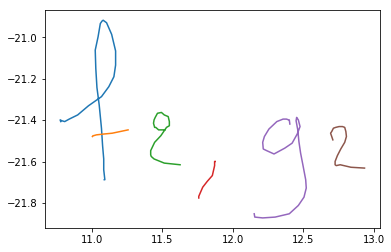

In [0]:
plt.plot(listi(poslislis[0], 0),-listi(poslislis[0], 1))
plt.plot(listi(poslislis[1], 0),-listi(poslislis[1], 1))
plt.plot(listi(poslislis[2], 0),-listi(poslislis[2], 1))
plt.plot(listi(poslislis[3], 0),-listi(poslislis[3], 1))
plt.plot(listi(poslislis[4], 0),-listi(poslislis[4], 1))
plt.plot(listi(poslislis[5], 0),-listi(poslislis[5], 1))

In [0]:
rdplislis = [rdp(lis, epsilon=0.5) for lis in poslislis]

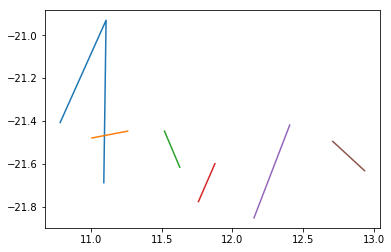

In [0]:
for i in range(len(rdplislis)):
  plt.plot(listi(rdplislis[i], 0),-listi(rdplislis[i], 1))

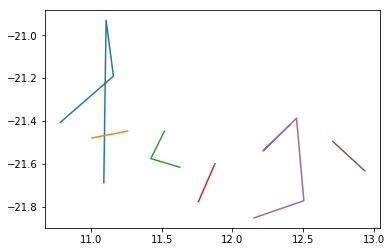

In [0]:
rdplislis = [rdp(lis, epsilon=0.1) for lis in poslislis]
for i in range(len(rdplislis)):
  plt.plot(listi(rdplislis[i], 0),-listi(rdplislis[i], 1))

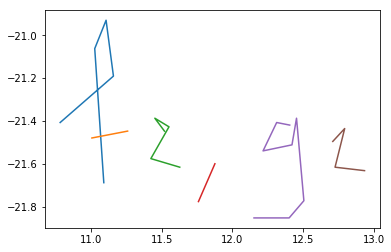

In [0]:
rdplislis = [rdp(lis, epsilon=0.05) for lis in poslislis]
for i in range(len(rdplislis)):
  plt.plot(listi(rdplislis[i], 0),-listi(rdplislis[i], 1))

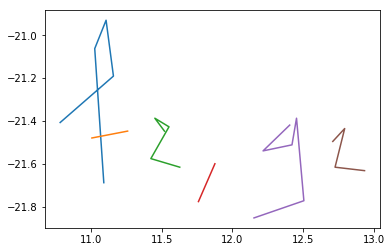

In [0]:
rdplislis = [rdp(lis, epsilon=0.07) for lis in poslislis]
for i in range(len(rdplislis)):
  plt.plot(listi(rdplislis[i], 0),-listi(rdplislis[i], 1))

epsilon 0.05 seems enough. 0.07 might OK, too.

In [0]:
train_raw_list[0][1]

'f_2, g_2'

In [0]:
rdp(poslislis[2], epsilon=0.1)

[[11.5199, 21.4472], [11.4236, 21.5756], [11.6282, 21.6157]]

In [0]:
rdp(poslislis[2], epsilon=0.05)

[[11.5199, 21.4472],
 [11.4517, 21.387],
 [11.552, 21.4272],
 [11.4236, 21.5756],
 [11.6282, 21.6157]]

In [0]:
train_raw_list[0][0]

'Train/INKMLs/Train_2014/formulaire028-equation067.inkml'

In [0]:
one_stroke_list = train_raw_list[0][4]

In [0]:
one_stroke_str = [cell.strip(" ").split(" ") for cell in one_stroke_list[0].split(",")]

In [0]:
one_stroke = [[float(tup[0]), float(tup[1])] for tup in one_stroke_str]

In [0]:
one_stroke

[[10.7816, 21.4071],
 [10.7776, 21.3991],
 [10.7896, 21.4031],
 [10.8097, 21.4071],
 [10.8418, 21.3951],
 [10.9019, 21.375],
 [10.9782, 21.3309],
 [11.0705, 21.2867],
 [11.1226, 21.2386],
 [11.1587, 21.1904],
 [11.1708, 21.1342],
 [11.1708, 21.066],
 [11.1427, 20.9858],
 [11.1066, 20.9296],
 [11.0825, 20.9176],
 [11.0745, 20.9216],
 [11.0624, 20.9336],
 [11.0464, 20.9978],
 [11.0263, 21.062],
 [11.0303, 21.1503],
 [11.0384, 21.2426],
 [11.0544, 21.3268],
 [11.0705, 21.4392],
 [11.0785, 21.5235],
 [11.0865, 21.5877],
 [11.0865, 21.6398],
 [11.0905, 21.6639],
 [11.0945, 21.688],
 [11.0905, 21.688]]

In [0]:
rdp(one_stroke, epsilon=1.0)

[[10.7816, 21.4071], [11.0905, 21.688]]

In [0]:
input_from_encoder_t = tf.placeholder(tf.float32, shape=[None, None, None, ENC_OUTPUT_DIM])
#  # (batch, 98)
decoder_input_t = tf.placeholder(tf.int8, shape=[None, MAX_TRAIN_LEN])


In [0]:
input_from_encoder_t.shape

In [0]:
flattened_enc_output = Reshape((-1, ENC_OUTPUT_DIM))(input_from_encoder_t)
masked_input_from_enc = Masking(mask_value = np.nan,input_shape=(None, ENC_OUTPUT_DIM))(flattened_enc_output)


In [0]:
rdp_stroke_input.shape

(9862, 1948, 3)

In [0]:
def list3_to_stroke_len(list3):
  return [len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3]


In [0]:
train_lens = list3_to_stroke_len(train_rdplis)

In [0]:
len(train_lens)

9862

(array([1.383e+03, 1.258e+03, 9.100e+02, 7.090e+02, 6.070e+02, 5.320e+02,
        5.270e+02, 4.430e+02, 4.320e+02, 3.800e+02, 3.860e+02, 3.670e+02,
        3.130e+02, 2.470e+02, 2.330e+02, 2.150e+02, 1.830e+02, 1.240e+02,
        1.060e+02, 8.600e+01, 8.400e+01, 8.200e+01, 5.000e+01, 3.900e+01,
        4.300e+01, 2.300e+01, 2.100e+01, 1.500e+01, 5.000e+00, 1.400e+01,
        1.000e+01, 4.000e+00, 6.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([   9.  ,   47.78,   86.56,  125.34,  164.12,  202.9 ,  241.68,
         280.46,  319.24,  358.02,  396.8 ,  435.58,  474.36,  513.14,
         551.92,  590.7 ,  629.48,  668.26,  707.04,  745.82,  784.6 ,
         823.38,  862.16,  900.94,  939.72,  978.5 , 1017.28, 1056.06,
        1094.84, 1133.62, 1172.4 , 1211.18, 1249.96, 1288.74, 1327.52,
        1366.3 , 1405

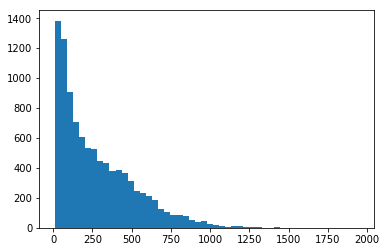

In [0]:
plt.hist(train_lens, bins=50)

In [0]:
(np.array(train_lens)<500).sum()

8131

In [0]:
(np.array(train_lens)>=500).sum()

1731

### Export model

In [0]:
def create_serving_input():
  stroke_input_t = tf.placeholder(tf.int32, shape=[None, None, INPUT_TYPE_DIM], name='stroke_input')
  decoder_input_t = tf.placeholder(tf.int32, shape=[None, None], name='input_decoder')

  input_fn_recv = tf.estimator.export.build_raw_serving_input_receiver_fn({
      "input_stroke": stroke_input_t,
      "input_decoder": decoder_input_t
  })
  return input_fn_recv

In [0]:
  tpu_estimator.export_savedmodel(
    export_dir_base="gs://karino2-tegashiki/models/model_vec_export_30000",
    serving_input_receiver_fn=create_serving_input())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from gs://karino2-tegashiki/models/model_vec/model.ckpt-30000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://karino2-tegashiki/models/model_vec_export_30000/temp-b'1558433709'/saved_model.pb


b'gs://karino2-tegashiki/models/model_vec_export_30000/1558433709'

In [0]:
def create_serving_input():
  stroke_input_t = tf.placeholder(tf.int32, shape=[None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM], name='stroke_input')
  decoder_input_t = tf.placeholder(tf.int32, shape=[None, MAX_TRAIN_LEN], name='input_decoder')

  input_fn_recv = tf.estimator.export.build_raw_serving_input_receiver_fn({
      "input_stroke": stroke_input_t,
      "input_decoder": decoder_input_t
  })
  return input_fn_recv

In [0]:
def serving_input_receiver_fn():
  """An input receiver that expects a serialized tf.Example."""
  serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[default_batch_size],
                                         name='input_example_tensor')
  receiver_tensors = {'examples': serialized_tf_example}
  features = tf.parse_example(serialized_tf_example, feature_spec)
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

### Misc

In [0]:
tpu_estimator.train(
    # input_fn=tpu_input_fn_wrapper,
    # input_fn=tpu_input_fn(),
    # input_fn=create_input_fn(BATCH_SIZE),
    input_fn = tpu_input_fn,
    max_steps=100)

In [0]:
def sparse_softmax_cross_entropy_with_mask_org(sparse_labels, logit, mask, vocabsize=VOCAB_SIZE):
  mask = tf.cast(mask, tf.float32)
  mask_expands = tf.expand_dims(mask, axis=2)
  
  dense_labels = tf.one_hot(sparse_labels, vocabsize)
  
  explogit = tf.exp(logit)
  softmax = explogit / tf.reduce_sum(explogit, -1, keepdims=True)
  like = dense_labels * tf.log(softmax)
  cross_for_seq = -tf.reduce_sum(mask_expands*like, axis=[1, 2])
  # seq_counts = tf.reduce_sum(tf.cast(mask, tf.float32), axis=[-1])
  # like_counts = seq_counts*vocabsize
  # cross = tf.reduce_mean(cross_for_seq/like_counts)
  cross = tf.reduce_mean(cross_for_seq)
  
  return cross
  

In [0]:
yt = create_model(input_from_encoder_t, decoder_input_t)

In [0]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)


In [0]:
res = sess.run([masked_input_from_enc], feed_dict={input_from_encoder_t: one_batch_pad, decoder_input_t: batch_decoder_input})

In [0]:
res = res[0]

In [0]:
res.shape

In [0]:
res[0]

In [0]:
sess.run([yt], feed_dict={input_from_encoder_t: one_batch_pad, decoder_input_t: batch_decoder_input})

In [0]:
all_losses = []

In [0]:
batch_decoder_input[0].shape

In [0]:
np.mean([1, 2, 3])

In [0]:
input_from_encoder_t = input1
decoder_input_t = input2

In [0]:
from tqdm.autonotebook import tqdm as tqdmn
def run_one_epoch(enc_features, decoder_inputs, decoder_labels):
  losses = []
  for i, fs in tqdmn(enumerate(enc_features)):
    one_dec_input = decoder_inputs[i]
    one_dec_label = decoder_labels[i]
    _, loss_value = sess.run((train_op, loss), feed_dict={input_from_encoder_t:[fs], decoder_input_t: [one_dec_input], decoder_label_t: [one_dec_label] })
    losses.append(loss_value)
  return np.mean(losses)


In [0]:
run_one_epoch(one_batch, batch_decoder_input, batch_decoder_target)

In [0]:
all_loss = []


In [0]:
for i in range(40):
  loss_value = run_one_epoch(one_batch, batch_decoder_input, batch_decoder_target)
  all_loss.append(loss_value)
  print("{},{}".format(i, loss_value))

In [0]:
import matplotlib.pyplot as plt

In [0]:
plt.plot(range(1, len(all_loss)+1), all_loss, 'bo', label='Training loss')

In [0]:
[arr.shape for arr in one_batch]

In [0]:
one_batch_pad = pad_batch(one_batch)

In [0]:
loss_list = []
all_losses = []

In [0]:
history = model.fit([one_batch_pad, batch_decoder_input],batch_decoder_target,
          batch_size=1,epochs=100)

In [0]:
losses = history.history['loss']
all_losses.extend(losses)
loss_list.append(losses)

In [0]:
plt.plot(range(1, len(all_losses)+1), all_losses, 'bo', label='Training loss')

In [0]:
all_losses = loss_list[0].copy()

In [0]:
loss_list = [losses]

In [0]:
len(one_batch_padded)

In [0]:
decoder_input_data.shape

In [0]:
one_batch_keys = list(train_features.keys())

In [0]:
len(one_batch_keys)

In [0]:
one_batch = [train_features[key] for key in one_batch_keys]

In [0]:
one_batch_padded = pad_batch(one_batch)

In [0]:
batch_decoder_input = np.zeros((100, 98))
batch_decoder_target = np.zeros((100, 98, VOCAB_SIZE))


In [0]:
for i, key in enumerate(one_batch_keys):
  batch_decoder_input[i, :] = decoder_input_data[name2idx[key], :]
  batch_decoder_target[i, :, :] = decoder_target_data[name2idx[key], :, :]

In [0]:
model.fit([one_batch_padded, batch_decoder_input],batch_decoder_target,
          batch_size=1,epochs=5)

In [0]:
np.eye(VOCAB_SIZE)[]

In [0]:
decoder_input_data.shape

In [0]:
decoder_input_data[0, 0:10, 0]

In [0]:
tmp = np.squeeze(decoder_input_data, axis=2)

In [0]:
tmp[0, 0:5].astype(int)

In [0]:
np.eye(VOCAB_SIZE)[tmp.astype(int)].shape

In [0]:
with gzip.open("offline-train.pkl.gz",'rb') as f:
    train_images = pickle.load(f)

In [0]:
train_images['KME1G3_9_sub_10'].shape

In [0]:
maxw = np.max([v.shape[1] for v in train_images.values()])

In [0]:
maxw

In [0]:
maxh = np.max([v.shape[2] for v in train_images.values()])

In [0]:
maxh

In [0]:
train_images['KME1G3_9_sub_10'][0, 100:105, 100:105]